# Physical Beamformer testing

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from scipy.signal import resample
from playsound import playsound
from os import listdir
from os.path import isfile, join

### Build Anechoic Simulation Room

In [155]:
fs = 48000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 10 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
v_sound = 343.0 # speed of sound in air

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place mics

In [156]:
# design parameters of array
array_loc = [5, 0.1] # x/y location of array center
n_mics = 8 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Load Recorded Signals

Stores them in microphone objects

In [157]:
mic_signals_folder = '../array_samples/y=2,x=1_twosource_3'
mic_signals_filenames = [f for f in listdir(mic_signals_folder) if isfile(join(mic_signals_folder, f))]
mic_signals_filenames.sort()

for i in range(n_mics):
    file_str = mic_signals_folder + '/' + mic_signals_filenames[i]
    rate, audio = wavfile.read(file_str)

    # ensure sampling rates of all audio matches
    if rate != fs:
        num_samples = int(len(audio) * fs / rate)
        audio = resample(audio, num_samples)

    if i == 0:
        mic_signals = np.zeros((n_mics, len(audio)))

    mic_signals[n_mics-1-i, :] = audio

room.mic_array.signals = mic_signals

/var/folders/_f/h8xwd2k15l36zgym21rpns740000gn/T/ipykernel_56238/1786311218.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, audio = wavfile.read(file_str)


In [158]:
# compute time-varying signal covariance matrix, in small chunks
snapshot_size = 1024
n_snapshots = mic_signals.shape[1] // snapshot_size
diag_loading = 0.0 # ensures nonzero eigenvalues
R_n = np.zeros((n_mics, n_mics, n_snapshots))

for i in range(n_snapshots):
    # compute different R_n for each snapshot
    signal_snapshot = mic_signals[:, snapshot_size*i:snapshot_size*(i+1)]
    R_n[:, :, i] = (1.0/snapshot_size) * np.cov(signal_snapshot) + diag_loading * (np.eye(n_mics))

### Isolate sources with beamforming

In [159]:
# add guessed locations of sources to room
n_source = 2
doa_azimuths = np.array([np.arctan2(2,1), np.arctan2(2,-1)]) # ground truth
# doa_azimuths = np.array([55.86206897, 93.10344828])*np.pi/180.0 # DOA estimate

# add guessed locations of sources to room
guess_dist = 3 # guessed distance away from array - choose far distance for precise beam
guess_source_locs = np.empty((2, n_source))

output = np.zeros((n_snapshots*snapshot_size))

for i in range(n_source):
    guess_source_locs[0, i] = array_loc[0] + guess_dist*np.cos(doa_azimuths[i])
    guess_source_locs[1, i] = array_loc[1] + guess_dist*np.sin(doa_azimuths[i])

# Beamforming algorithm for each source
out_filepath = '../output_samples/physical_tests'

for i in range(guess_source_locs.shape[1]):
    current_interferers = guess_source_locs
    current_interferers = np.delete(current_interferers, i, 1)

    interf = pra.soundsource.SoundSource([0, 0])
    interf.images = current_interferers

    source = pra.soundsource.SoundSource([0, 0])
    source.images = np.array([[guess_source_locs[0, i]], [guess_source_locs[1, i]]])

    for j in range(n_snapshots):
        room.mic_array.signals = mic_signals[:, snapshot_size*j:snapshot_size*(j+1)]
        mic_array.rake_max_sinr_weights(
            source=source,
            interferer=interf,
            R_n=R_n[:,:,j] # estimated noise covariance matrix
        )
        mic_array.filters_from_weights() # process with time domain filters for now, can also use FD directly
        output[snapshot_size*j:snapshot_size*(j+1)] = mic_array.process()[snapshot_size//2:3*snapshot_size//2]

    # save processed sound as output
    out_norm = pra.normalize(output)
    wavfile.write(out_filepath + '/isolated_src' + str(i+1) + '.wav', fs, out_norm)

### Evaluate performance

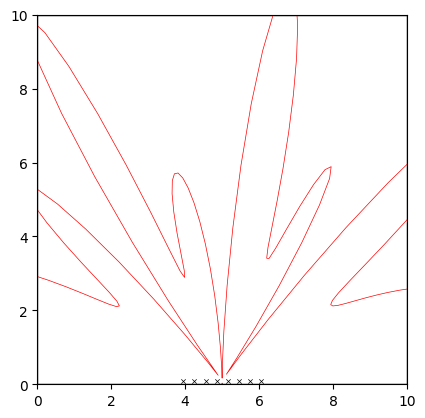

In [161]:
# plot peam pattern
fig, ax = room.plot(freq=[1000], img_order=0)